In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import json
from PIL import Image

In [2]:
###Lengthy process to download and unzip lot of images and text


ann_folder = '/anns/'
ann_url = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
ann_zip = tf.keras.utils.get_file('captions.zip',
                                  cache_subdir=os.path.abspath('.'),
                                  origin=ann_url,
                                  extract=True)
ann_file = os.path.dirname(
    ann_zip)+'/annotations/captions_train2014.json'
os.remove(ann_zip)

image_folder = '/train2014/'
image_url = 'http://images.cocodataset.org/zips/train2014.zip'
image_zip = tf.keras.utils.get_file('train2014.zip',
                                    cache_subdir=os.path.abspath('.'),
                                    origin=image_url,
                                    extract=True)
PATH = os.path.dirname(image_zip) + image_folder
os.remove(image_zip)
with open(ann_file, 'r') as f:
    anns = json.load(f)

13510574080/13510573713 [==============================] - 327s 0us/step


In [3]:
caption_path = collections.defaultdict(list)
for val in anns['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    caption_path[image_path].append(caption)

image_paths = list(caption_path.keys())
random.shuffle(image_paths)
train_paths = image_paths[:6000]
print(len(train_paths))

6000


<start> a group of cattle standing and laying in an enclose pen <end>


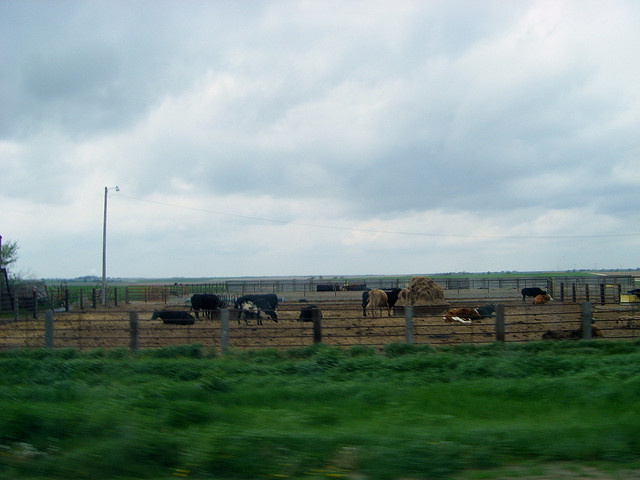

In [4]:
train_captions = []
img_vector = []
for image_path in train_paths:
    caption_list = caption_path[image_path]
    train_captions.extend(caption_list)
    img_vector.extend([image_path] * len(caption_list))

print(train_captions[0])
Image.open(img_vector[0])

In [5]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [6]:
inceptionv3 = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = inceptionv3.input
hidden_layer = inceptionv3.layers[-1].output
inception_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [7]:
encode_train = sorted(set(img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)
for img, path in image_dataset:
    batch_features = inception_model(img)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [7]:
def max_len(tensor):
    return max(len(t) for t in tensor)

In [8]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(
    train_seqs, padding='post')
max_length = max_len(train_seqs)
max_length

51

In [10]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_vector, cap_vector):
    img_to_cap_vector[img].append(cap)
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
slice_index = int(len(img_keys)*0.8)
img_train_keys, img_val_keys = img_keys[:
                                        slice_index], img_keys[slice_index:]
img_train = []
cap_train = []
for imgt in img_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])
img_val = []
cap_val = []
for imgv in img_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])
len(img_train), len(cap_train), len(img_val), len(cap_val)

(24012, 24012, 6005, 6005)

In [11]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_train) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 64

In [12]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.f1 = tf.keras.layers.Dense(units)
        self.f2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_layer = tf.expand_dims(hidden, 1)
        attention = (tf.nn.tanh(self.f1(features) +
                                self.f2(hidden_layer)))
        score = self.V(attention)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [15]:
class Inception_Input(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Inception_Input, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = Attention(self.units)

    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [17]:
encoder = Inception_Input(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [18]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [19]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [20]:
start_epoch = 0
loss_plot = []

In [21]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [22]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(
                f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    loss_plot.append(total_loss / num_steps)
    if epoch % 5 == 0:
        ckpt_manager.save()
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')

Epoch 1 Batch 0 Loss 2.1539
Epoch 1 Batch 100 Loss 1.2018
Epoch 1 Batch 200 Loss 0.9825
Epoch 1 Batch 300 Loss 0.9787
Epoch 1 Loss 1.082965
Epoch 2 Batch 0 Loss 0.9072
Epoch 2 Batch 100 Loss 0.8245
Epoch 2 Batch 200 Loss 0.8328
Epoch 2 Batch 300 Loss 0.8568
Epoch 2 Loss 0.817645
Epoch 3 Batch 0 Loss 0.8074
Epoch 3 Batch 100 Loss 0.7012
Epoch 3 Batch 200 Loss 0.7473
Epoch 3 Batch 300 Loss 0.7394
Epoch 3 Loss 0.734774
Epoch 4 Batch 0 Loss 0.7262
Epoch 4 Batch 100 Loss 0.6859
Epoch 4 Batch 200 Loss 0.6367
Epoch 4 Batch 300 Loss 0.6783
Epoch 4 Loss 0.681350
Epoch 5 Batch 0 Loss 0.7163
Epoch 5 Batch 100 Loss 0.6329
Epoch 5 Batch 200 Loss 0.7014
Epoch 5 Batch 300 Loss 0.6396
Epoch 5 Loss 0.637805
Epoch 6 Batch 0 Loss 0.6665
Epoch 6 Batch 100 Loss 0.6291
Epoch 6 Batch 200 Loss 0.6597
Epoch 6 Batch 300 Loss 0.5638
Epoch 6 Loss 0.600839
Epoch 7 Batch 0 Loss 0.5548
Epoch 7 Batch 100 Loss 0.5695
Epoch 7 Batch 200 Loss 0.5507
Epoch 7 Batch 300 Loss 0.5703
Epoch 7 Loss 0.568654
Epoch 8 Batch 0 Loss

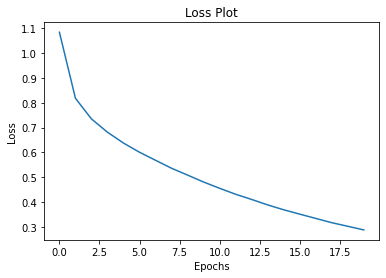

In [23]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [24]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [25]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a brown bear is ankle deep in some water <end>
Prediction Caption: a brown bear sitting in the ground covered field with each other <end>


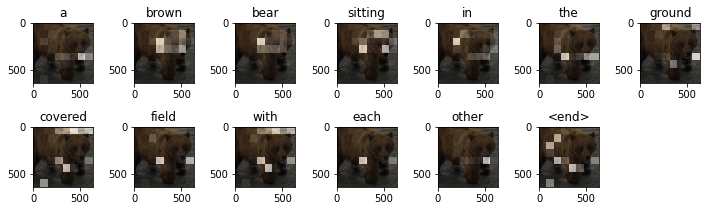

In [30]:
# captions on the validation set
rid = np.random.randint(0, len(img_val))
image = img_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [27]:
!cd checkpoints/train && ls

checkpoint		    ckpt-3.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-3.index
ckpt-1.index		    ckpt-4.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-4.index
ckpt-2.index


In [54]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
!mv checkpoints gdrive/MyDrive/image-caption/checkpoints

mv: cannot stat 'checkpoints': No such file or directory


In [56]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
tokenizer

In [58]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [62]:
!mv /content/tokenizer.pickle grive/MyDrive/image-caption/

mv: cannot move '/content/tokenizer.pickle' to 'grive/MyDrive/image-caption/': No such file or directory
